## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import numpy as np

# Record_fp_tp
class Record_tp_tn(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        cnf_matrix = confusion_matrix(y_true, y_pred)
        
        print(cnf_matrix)
        
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        print(FP, FN, TP, TN)
        logs["TP"] = TP
        logs["TN"] = TN
        
rec_tptn = Record_tp_tn()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

valid_tp = model.history.history['TP']
valid_tn = model.history.history['TN']

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 9s 184us/step - loss: 1.3450 - accuracy: 0.5324 - val_loss: 1.5000 - val_accuracy: 0.4724
[[ 988   12    0    0    0    0    0    0    0    0]
 [ 607  393    0    0    0    0    0    0    0    0]
 [ 991    9    0    0    0    0    0    0    0    0]
 [ 989   11    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [ 996    4    0    0    0    0    0    0    0    0]
 [ 997    3    0    0    0    0    0    0    0    0]
 [ 995    5    0    0    0    0    0    0    0    0]
 [ 976   24    0    0    0    0    0    0    0    0]
 [ 895  105    0    0    0    0    0    0    0    0]]
[8446.  173.    0.    0.    0.    0.    0.    0.    0.    0.] [  12.  607. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [988. 393.   0.   0.   0.   0.   0.   0.   0.   0.] [ 554. 8827. 9000. 9000. 9000. 9000. 9000. 9000. 9000. 9000.]
Epoch 10/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.3123 - accu

50000/50000 [==============================] - 9s 190us/step - loss: 1.0930 - accuracy: 0.6258 - val_loss: 1.4513 - val_accuracy: 0.4962
[[986  14   0   0   0   0   0   0   0   0]
 [509 491   0   0   0   0   0   0   0   0]
 [986  14   0   0   0   0   0   0   0   0]
 [981  19   0   0   0   0   0   0   0   0]
 [994   6   0   0   0   0   0   0   0   0]
 [996   4   0   0   0   0   0   0   0   0]
 [990  10   0   0   0   0   0   0   0   0]
 [992   8   0   0   0   0   0   0   0   0]
 [963  37   0   0   0   0   0   0   0   0]
 [892 108   0   0   0   0   0   0   0   0]]
[8303.  220.    0.    0.    0.    0.    0.    0.    0.    0.] [  14.  509. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [986. 491.   0.   0.   0.   0.   0.   0.   0.   0.] [ 697. 8780. 9000. 9000. 9000. 9000. 9000. 9000. 9000. 9000.]
Epoch 20/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.0709 - accuracy: 0.6336 - val_loss: 1.4472 - val_accuracy: 0.5002
[[988  12   0   0   0   0   0   0   0   0]
 [

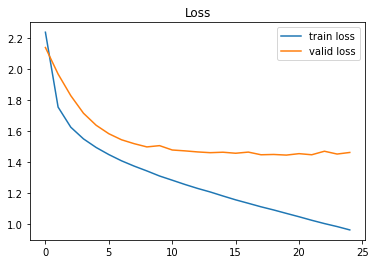

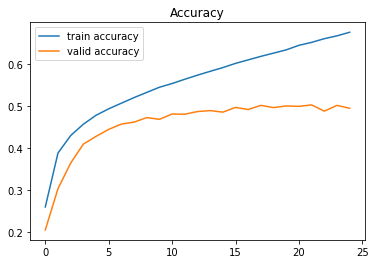

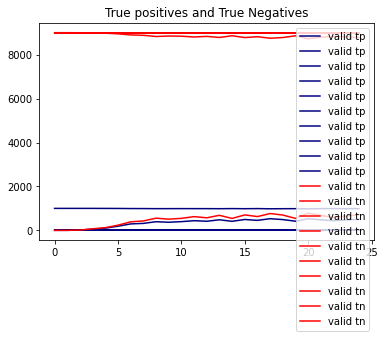

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
